In [1]:
!pip install pyvirtualdisplay Pillow


# SUMO Setups

In [146]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from tqdm import tqdm
from dotenv import load_dotenv
from gymnasium import spaces
import matplotlib.patches as patches
import shutil

SUMO_HOME = 'C:\\Program Files (x86)\\Eclipse\\Sumo'

os.environ['SUMO_HOME'] = SUMO_HOME

# Print the SUMO_HOME environment variable to verify
print("SUMO_HOME is set to:", os.environ.get('SUMO_HOME'))

# Check if the SUMO_HOME path exists
print("Does SUMO_HOME exist?", os.path.exists(os.environ.get('SUMO_HOME')))


# Define file paths
net_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.net.xml/osm.net.xml'
route_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.rou.xml'
out_csv_name = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.csv'
config_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.sumocfg'


SUMO_HOME is set to: C:\Program Files (x86)\Eclipse\Sumo
Does SUMO_HOME exist? True


## Importing Required libraries

In [63]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from tqdm import tqdm
import os
from dotenv import load_dotenv
import sumo_rl
import traci

# Environment Setup

In [ ]:
class Environment:
    def __init__(self, env_name, route_file, net_file, out_csv_name, render_mode='human', num_seconds=100000):
        self.env_name = env_name
        self.use_gui = True if render_mode == 'human' else False
        self.route_file = route_file
        self.net_file = net_file
        self.out_csv_name = out_csv_name
        self.env = gym.make(
                        env_name,
                        net_file=net_file,
                        route_file=route_file,
                        out_csv_name=out_csv_name,
                        use_gui=self.use_gui,
                        num_seconds=num_seconds
                    )
     
        self.state, _ = self.env.reset()
        self.done = False
        self.observation_space = self.env.observation_space.shape[0]
        self.action_space = self.env.action_space
        self.traffic_signals = self.env.traffic_signals
    
    def reset(self):
        self.state, _ = self.env.reset()
        self.done = False
        return self.state
    
    def custom_reward(self, traffic_signal, reward_type='average_speed', reward_method='simple'):
        # print("Inside custom reward method")
        if reward_method == 'simple':
            match reward_type:
                case 'average_speed':
                    return traffic_signal.get_avgerage_speed()
                case 'congesion':
                    return -1 * traffic_signal.get_pressure()
                case 'emissions':
                    return -1* traffic_signal.get_emission_co2()
                case 'throughput':
                    return traffic_signal.get_throughput()

        else:
            # Weighted sum of the metrics
            reward = 0
            if weights is None:
                weights = {
                    'average_speed': 0.4,
                    'waiting_time': 0.3,
                    'emissions': 0.2,
                    'throughput': 0.1
                }

            # Calculate individual rewards
            average_speed = traffic_signal.get_average_speed()
            waiting_time = -1* traffic_signal._diff_waiting_time_reward()
            total_queue = -1 * traffic_signal.get_total_queued()
            congesion = traffic_signal.get_pressure()

            print(average_speed, waiting_time, total_queue, congesion)
            weighted_reward = (
                weights['average_speed'] * average_speed +
                weights['waiting_time'] * waiting_time +
                weights['emissions'] * total_queue +
                weights['throughput'] * congesion
            )

            return weighted_reward
            
            
    def step(self, action):
        # print("Inside step method")
        next_state, reward, terminated, truncated, info = self.env.step(action)
        # print("Step taken", next_state, terminated, truncated, info)

        # print("Traffic signals:", list(self.traffic_signals.values())[0])
        # traffic_signal = list(self.traffic_signals.values())[0]
        # print("Pressure:", traffic_signal.get_pressure())
        # # print(traffic_signal.get_average_speed(), traffic_signal.get_total_queued(), traffic_signal._diff_waiting_time_reward(), traffic_signal.get_pressure())
        # reward = self.custom_reward(traffic_signal, reward_type='congesion', reward_method='simple')
        # print("Reward:", reward)

        self.state = next_state
        self.done = terminated
        return next_state, reward, self.done or truncated
    
    def render(self):
        self.env.render()
    
    def close(self):
        try:
            self.env.close()
            if traci.isLoaded():
                traci.close()
            print("Env and Traci closed successfully.")
        except Exception as e:
            print("Error while closing the environment:", e)
    
    def get_state(self):
        return self.state


## Random Agent Run Basic

## Running Environment (Simple Intersection)

In [136]:
# Define paths to the network and route files (Buffalo Road Intersection)

# net_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.net.xml/osm.net.xml'
# route_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.rou.xml'
# out_csv_name = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.csv'


# Using Custom simple Traffic Intersection
nets_dir = 'nets'

file_name = 'single_intersection_simple'
out_csv_name = f'{file_name}.csv'

nets_file = os.path.join(nets_dir, f'{file_name}.net.xml')
routes_file = os.path.join(nets_dir, f'{file_name}.rou.xml')
out_csv_name = os.path.join(nets_dir, f'{file_name}.csv')

file_exists = lambda file_path: os.path.exists(file_path)

if not file_exists(nets_file):
    raise FileNotFoundError(f"Net file not found: {net_file}")
if not file_exists(routes_file):
    raise FileNotFoundError(f"Route file not found: {route_file}")


# Instantiate the environment
sumo_env = Environment('sumo-rl-v0', net_file=nets_file, route_file=routes_file, out_csv_name=out_csv_name, render_mode=None, num_seconds=100000)

print("Observation Space:", sumo_env.observation_space)
print("Action Space:", sumo_env.action_space.n)
print("Initial State:", sumo_env.state)

max_steps = 100

try:
    print("action space", sumo_env.action_space)
    for step in range(max_steps):
        # sumo_env.render()
        action = sumo_env.env.action_space.sample()
        next_state, reward, done = sumo_env.step(action)
        print("Action ", action, " Reward ", reward, " Done ", done, "observation", next_state)
        
        if done:
            sumo_env.reset()
            break

except KeyboardInterrupt:
    print("Keyboard interrupt detected. Closing the environment.")

except Exception as e:
    print("Error occurred:", e)

finally:
    sumo_env.close()

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.traffic_signals to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.traffic_signals` for environment variables or `env.get_wrapper_attr('traffic_signals')` that will search the reminding wrappers.
  logger.warn(


Observation Space: 11
Action Space: 2
Initial State: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
action space Discrete(2)
Action  1  Reward  0.0  Done  False observation [1.         0.         0.         0.05048805 0.         0.05283551
 0.05283551 0.         0.         0.         0.        ]
Action  1  Reward  0.0  Done  False observation [1.         0.         1.         0.05048805 0.05048805 0.15850651
 0.15850651 0.         0.         0.         0.        ]
Action  1  Reward  0.0  Done  False observation [0.         1.         0.         0.1009761  0.05048805 0.21134202
 0.21134202 0.         0.         0.         0.        ]
Action  0  Reward  -0.03  Done  False observation [0.         1.         1.         0.1009761  0.05048805 0.10567101
 0.15850651 0.05048805 0.         0.         0.        ]
Action  0  Reward  -0.010000000000000002  Done  False observation [1.         0.         0.         0.05048805 0.         0.15850651
 0.15850651 0.         0.         0.05283551 0.05283551]
Action 

# Training DQN

## DQN Network

In [12]:
# Setting up basic Neural Network for DQN
from torch import nn

input_nodes = 128

class DQN(nn.Module):
    def __init__(self, observation_size, action_size, input_nodes=128):
        super(DQN, self).__init__()
        print("Observation size Network", observation_size)
        print("Action size Network", action_size)

        self.fc1 = nn.Linear(observation_size, input_nodes)
        self.fc2 = nn.Linear(input_nodes, input_nodes)
        self.fc3 = nn.Linear(input_nodes, action_size)
        
    
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Replay Memory

In [5]:
# Class for Replay Memory
from collections import namedtuple, deque
import random

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## DQN Agent

In [144]:
# Setting up the Agent Class for doing the DQN 
class Agent:
    def __init__(self, env, epsilon, gamma, learning_rate, epsilon_decay, mem_size=5000):
        self.env = env
        self.state_size = env.observation_space
        self.action_size = env.action_space.n
        self.epsilon = epsilon
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.min_epsilon = 0.01
        self.max_epsilon = 1
        self.epsilon_decay = epsilon_decay

        self.memory_size_max = mem_size
        self.memory_buffer = ReplayMemory(self.memory_size_max)
        self.q_network = DQN(self.state_size, self.action_size)
        self.q_target_network = DQN(self.state_size, self.action_size)
        self.q_target_network.load_state_dict(self.q_network.state_dict())
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
    
    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = torch.FloatTensor(state).unsqueeze(0)    
            with torch.no_grad():
                q_values = self.q_network(state)
                return torch.argmax(q_values).item()
    
    def update_experience(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state).unsqueeze(0)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        action = torch.LongTensor([action]).view(-1, 1)
        reward = torch.FloatTensor([reward]).to(torch.float32)
        done = torch.FloatTensor([done]).to(torch.float32)
        self.memory_buffer.push(state, action, next_state, reward, done)

        if self.memory_buffer.__len__() > self.memory_size_max:
            self.memory_buffer.pop(0)

    def update_exploration_probability(self, episode):
        self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.epsilon_decay * episode)
    
    def optimize(self, batch_size, sample_threshold=0.1):
        if len(self.memory_buffer) < batch_size:
            return
        
        if len(self.memory_buffer) < sample_threshold * self.memory_size_max:
            return

        transitions = self.memory_buffer.sample(batch_size)
        batch = Transition(*zip(*transitions))
        
        # Convert the parameters to torch tensors
        # state_batch = torch.cat(batch.state)
        # action_batch = torch.tensor(batch.action).view(-1, 1)
        # reward_batch = torch.tensor(batch.reward).float()
        # next_state_batch = torch.cat(batch.next_state)

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        next_state_batch = torch.cat(batch.next_state)
        done_batch = torch.cat(batch.done)

        curr_q_vals = self.q_network(state_batch)
        curr_q_vals = curr_q_vals.gather(1, action_batch)

        # update target q value and current q values, backpropagate the loss
        with torch.no_grad():
            next_q_vals = self.q_target_network(next_state_batch)
            max_next_q_vals = torch.max(next_q_vals, 1)[0]
            target_q_vals = reward_batch + self.gamma * max_next_q_vals * (1 - done_batch)

        loss = self.loss_function(curr_q_vals.squeeze(), target_q_vals)
        self.optimizer.zero_grad()
        loss.backward()
        # Handling the exploding gradient problem
        nn.utils.clip_grad_norm_(self.q_network.parameters(), 1)
        self.optimizer.step()

        return loss.item()
    
    def update_target_network(self):
        self.q_target_network.load_state_dict(self.q_network.state_dict())
    

## Trainer DQN

In [139]:


def trainer_dqn(env, agent, n_episodes, batch_size, epsilon, gamma, learning_rate, epsilon_decay, C, max_steps=100):
    max_steps = 500
    use_wandb = os.environ.get('USE_WANDB', 'false').lower() == 'true'
    epsilon_start = 1
    epsilon_end = 0.01

    if use_wandb:
        wandb_config = {
            'env': env.env_name,
            'algorithm': 'DQN',
            'batch_size': batch_size,
            'gamma': gamma,
            'eps_start': epsilon_start,
            'eps_end': epsilon_end,
            'eps_decay': epsilon_decay,
            'target_update': C,
            'lr': learning_rate,
            'num_episodes': n_episodes,
            'max_timesteps': max_steps,
            'seed': 0
        }
        
        cust_wandb = WanDB(wandb_config, f'assignment-2-{env.env_name}', env.env_name)
       
    
    loss_list = []
    reward_list = []
    rewards_per_episode = {}
    epsilon_values = []

    p_bar = tqdm(range(n_episodes), colour='green', desc='Training progress', unit='Episode')
    

    tot_steps = 0

    try:
        for episode in p_bar:
            state = env.reset()
            done = False
            total_reward = 0
            total_loss = 0            
    
            while not done:
                    tot_steps += 1
                    action = agent.choose_action(state)
                    # print("Action ", action)
                    next_state, reward, done = env.step(action)

                    # print("Action ", action, " Reward ", reward)
                    # Save the transition in the replay memory
                    agent.update_experience(state, action, reward, next_state, done)

                    # Run the optimization step
                    loss = agent.optimize(batch_size)
                    if loss:
                        if use_wandb:
                            cust_wandb.wandb_log({
                                    'loss': loss, 
                                    'step_reward': reward, 
                                    'step': tot_steps
                                })
                        
                        total_loss += loss
                    total_reward += reward
                    state = next_state

                    if done:
                        break

                    if episode % C == 0:
                        agent.update_target_network()

            agent.update_exploration_probability(episode)
            epsilon_values.append(agent.epsilon)

            loss_list.append(total_loss)
            reward_list.append(total_reward)
            rewards_per_episode[episode] = total_reward

            if use_wandb:
                cust_wandb.wandb_log({
                            'epsilon': agent.epsilon,
                            'total_reward': total_reward,
                            'epsilon': agent.epsilon,
                            'total_loss': total_loss,
                            'episode': episode
                })
    except traci.exceptions.FatalTraCIError as e:
        print("TraCI error:", e)
        
    except KeyboardInterrupt:
        print("Keyboard interrupt detected. Closing the environment.")


    except Exception as e:
        print(f"Error occurred in episode {episode}, step {step_}: {e}")
        raise

        
    finally:
        if use_wandb:
            cust_wandb.wandb_finish()
            print(f'Episode: {episode}, Total Reward: {total_reward}, Loss: {total_loss}')
    env.close()        
    return reward_list, loss_list, rewards_per_episode, epsilon_values

## Training Agent

In [148]:
# Trainer method

n_episodes = 1000
batch_size = 64
epsilon = 1
gamma = 0.99
learning_rate = 1e-3
epsilon_decay = 0.995
C = 5
num_seconds = 500

nets_dir = 'nets'

file_name = 'single_intersection_simple'

nets_file = os.path.join(nets_dir, f'{file_name}.net.xml')
routes_file = os.path.join(nets_dir, f'{file_name}.rou.xml')
out_csv_name = os.path.join(nets_dir+"/results_csv", f'{file_name}.passenger.csv')

file_exists = lambda file_path: os.path.exists(file_path)

results_dir = os.path.join(nets_dir, 'results_csv')
if os.path.exists(results_dir):
    shutil.rmtree(results_dir)
os.makedirs(results_dir, exist_ok=True)

if not file_exists(nets_file):
    raise FileNotFoundError(f"Net file not found: {net_file}")
if not file_exists(routes_file):
    raise FileNotFoundError(f"Route file not found: {route_file}")

sumo_env = Environment('sumo-rl-v0', net_file=nets_file, route_file=routes_file, out_csv_name=out_csv_name, render_mode=None, num_seconds=num_seconds)


print("Observation Space:", sumo_env.observation_space)
print("Action Space:", sumo_env.action_space)
# print("Initial State:", sumo_env.state)

agent = Agent(sumo_env, epsilon, gamma, learning_rate, epsilon_decay)

rewards, losses, rewards_per_episode, epsilon_values = trainer_dqn(sumo_env, agent, n_episodes, batch_size, epsilon, gamma, learning_rate, epsilon_decay, C)

Observation Space: 11
Action Space: Discrete(2)
Observation size Network 11
Action size Network 2
Observation size Network 11
Action size Network 2


Training progress:   0%|          | 2/1000 [00:15<2:10:33,  7.85s/Episode]Exception ignored in: <function SumoEnvironment.__del__ at 0x000001BD1142C820>
Traceback (most recent call last):
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sumo_rl\environment\env.py", line 460, in __del__
    self.close()
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sumo_rl\environment\env.py", line 450, in close
    traci.close()
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\traci\main.py", line 262, in close
    connection.check().close(wait)
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\traci\connection.py", line 397, in close
    self._sendCmd(tc.CMD_CLOSE, None, None)
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\traci\connection.py", line 232, in _sendCmd
    return self._sendExact()
  File "c:\Users\ASUS\AppData\Local\Programs\Python

Env and Traci closed successfully.


## Evaluation

In [119]:
# Graph plotting methods
def epsilon_decay_plot(epsilon_values, environment_type):
  # plt.figure(figsize=(6, 4))
  plt.title(f'Epsilon Decay {environment_type}')
  plt.plot(epsilon_values)
  plt.xlabel('Episode', fontsize=18)
  plt.ylabel('Epsilon Values', fontsize=18)
  plt.title('Epsilon Decay', fontsize=26)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  # plt.ylim(ymin=0, ymax=1)
  # plt.xlim(xmin=0, xmax=500)
  plt.grid()
  plt.show()

def rewards_per_episode_plot(rewards_per_ep, environment_type, epsilons=[]):
  episodes = np.array(list(rewards_per_ep.keys())).flatten()
  rewards = np.array(list(rewards_per_ep.values())).flatten()

  plt.figure(figsize=(10, 6))
  plt.plot(episodes, rewards, marker='o', linestyle='-', markersize=4)
  plt.title(f'Rewards per Episode {environment_type}')
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.grid(True)
  plt.xticks(range(0, max(episodes)+1, max(1, len(episodes)//10)))

  plt.tight_layout()
  plt.show()

def rewards_per_episode_plot_2(rewards_per_ep, environment_type, epsilons=None, window_size=10):
    """
    Plots rewards per episode with optional smoothing.
    
    Args:
        rewards_per_ep (dict): A dictionary where keys are episodes and values are rewards.
        environment_type (str): The type of environment (for plot title).
        epsilons (list, optional): Epsilon values per episode, if you'd like to include them in the plot. Default is None.
        window_size (int, optional): The window size for moving average smoothing. Default is 10.
    """
    episodes = np.array(list(rewards_per_ep.keys())).flatten()
    rewards = np.array(list(rewards_per_ep.values())).flatten()

    plt.figure(figsize=(10, 6))
    plt.plot(episodes, rewards, marker='o', linestyle='-', markersize=4, label='Rewards per Episode')

    # Moving average for smoothing
    if window_size > 1:
        moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        plt.plot(episodes[:len(moving_avg)], moving_avg, color='r', label=f'Moving Avg (window={window_size})')

    plt.title(f'Rewards per Episode {environment_type}', fontsize=20)
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Reward', fontsize=14)
    plt.grid(True)
    
    # Include epsilon plot if provided
    if epsilons:
        ax2 = plt.gca().twinx()
        ax2.plot(episodes, epsilons, color='g', alpha=0.6, linestyle='--', label='Epsilon')
        ax2.set_ylabel('Epsilon', fontsize=14)
        ax2.tick_params(axis='y', labelsize=12)

    plt.legend()
    plt.tight_layout()
    plt.show()
    return plt


Average Rewards: -1.79598


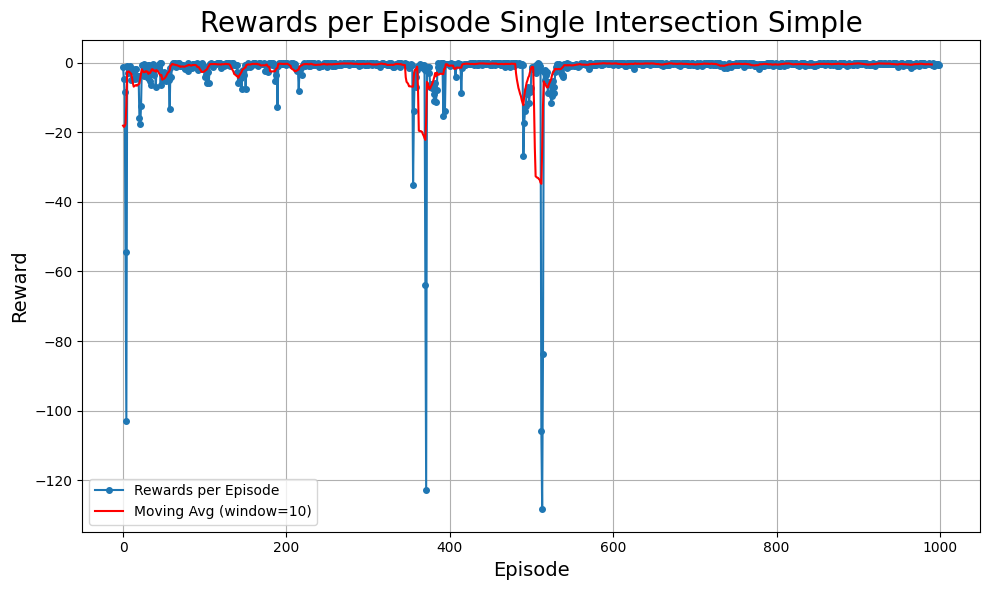

<module 'matplotlib.pyplot' from 'c:\\Users\\ASUS\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [153]:
print("Average Rewards:", np.mean(rewards))
rewards_per_episode_plot_2(rewards_per_episode, 'Single Intersection Simple', epsilon_values, window_size=10)

In [150]:
torch.save(agent.q_network.state_dict(), 'sumo_dqn.pth')

## Greedy Evaluation

In [122]:
def greedy_agent(agent, model, env, n_episodes=100):
    epsilon = 0 # For greedy, it chooses only exploitation
    reward_list = []
    rewards_per_episode = {}
    epsilon_values = []

    p_bar = tqdm(range(n_episodes), colour='red', desc='Testing Progress', unit='Episode')

    model.eval()
    total_rewards = []

    for episode in p_bar:
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = model(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, done = env.step(action)
            episode_reward += reward
            state = next_state

        reward_list.append(episode_reward)
        rewards_per_episode[episode] = episode_reward

    print(rewards_per_episode)
    rewards_per_ep_array = np.array(list(rewards_per_episode.values())).flatten()
    avg_rewards_over_eps = np.mean(rewards_per_ep_array)

    return avg_rewards_over_eps, rewards_per_episode, epsilon_values


In [151]:
model = DQN(sumo_env.observation_space, sumo_env.action_space.n)
model.load_state_dict(torch.load('sumo_dqn.pth'))

greedy_avg_rewards_over_eps, greedy_rewards_per_eps, epsilon_values = greedy_agent(agent,  model, sumo_env ,n_episodes=100)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_38112\690269224.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('sumo_dqn.pth'))


Observation size Network 11
Action size Network 2


Testing Progress:   0%|          | 0/100 [00:00<?, ?Episode/s]

Testing Progress: 100%|██████████| 100/100 [09:30<00:00,  5.71s/Episode]

{0: -0.2, 1: -0.79, 2: -0.10000000000000012, 3: -0.36, 4: -0.2200000000000001, 5: -0.05000000000000003, 6: -0.14999999999999988, 7: -0.86, 8: -0.66, 9: -0.4899999999999999, 10: -0.45000000000000023, 11: -1.39, 12: -0.41, 13: -0.48, 14: -0.21000000000000002, 15: -0.34999999999999987, 16: -0.14000000000000012, 17: -0.26, 18: -0.45, 19: -0.66, 20: -0.15, 21: -0.6, 22: -0.34, 23: -0.42, 24: -0.73, 25: -0.18, 26: -0.1200000000000001, 27: -0.51, 28: -0.2699999999999999, 29: -0.06, 30: -0.3800000000000002, 31: -0.5699999999999998, 32: -0.33, 33: -0.7900000000000001, 34: -0.05, 35: -0.3900000000000001, 36: -0.22, 37: -1.1100000000000003, 38: -0.040000000000000216, 39: -0.16000000000000023, 40: -0.030000000000000006, 41: -0.52, 42: -0.9, 43: -0.68, 44: -0.27, 45: -0.78, 46: -0.55, 47: -0.5799999999999998, 48: -0.26, 49: -0.13, 50: -0.020000000000000004, 51: -0.19, 52: -0.55, 53: -0.22, 54: -0.87, 55: -0.6199999999999998, 56: -0.38, 57: -0.29, 58: -0.62, 59: -0.4, 60: -0.8000000000000002, 61: -0

Avg Rewards per episode for Greedy Agent:  -1.4941


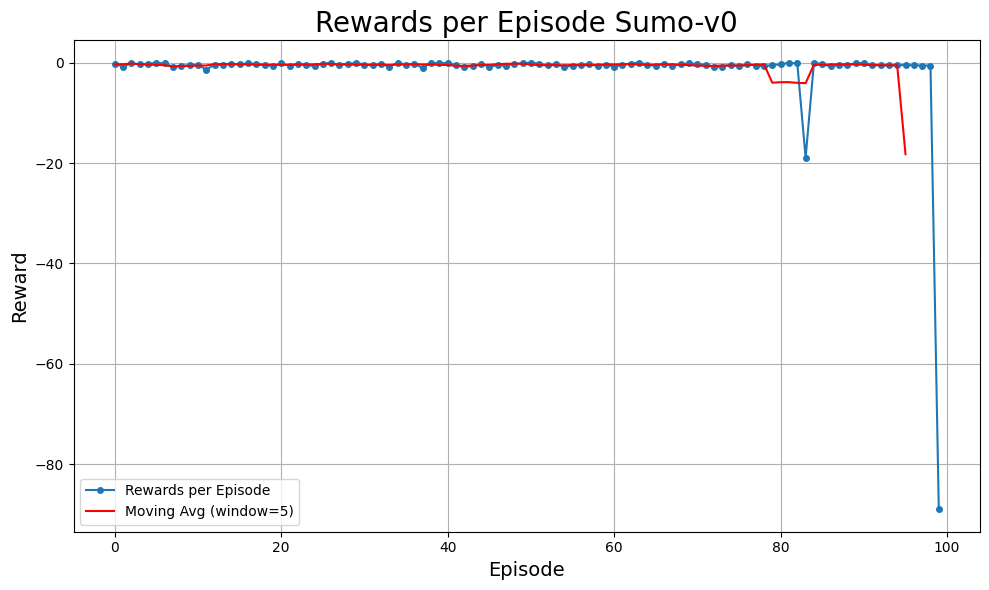

<module 'matplotlib.pyplot' from 'c:\\Users\\ASUS\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [152]:
print("Avg Rewards per episode for Greedy Agent: ", greedy_avg_rewards_over_eps)
rewards_per_episode_plot_2(greedy_rewards_per_eps, 'Sumo-v0', window_size=5)

# Training A3C

In [ ]:
from a3c_sumo import train_a3c

nets_dir = 'nets'

file_name = 'single_intersection_simple'

nets_file = os.path.join(nets_dir, f'{file_name}.net.xml')
routes_file = os.path.join(nets_dir, f'{file_name}.rou.xml')

num_seconds = 1000
n_episodes = 10
sumo_env = Environment('sumo-rl-v0', net_file=nets_file, route_file=routes_file, out_csv_name=out_csv_name, render_mode=None, num_seconds=num_seconds)

print("Observation Space:", sumo_env.observation_space)
print("Action Space:", sumo_env.action_space)
print("Initial State:", sumo_env.state)

# max_steps = 1000

input_dims = sumo_env.observation_space
actions = sumo_env.action_space.n
# Train the models
# train_a3c(sumo_env, max_steps=1000, num_episodes=10, gamma=0.99, lr=0.001, beta=0.01, num_processes=4)
train_a3c(sumo_env, input_dims=[input_dims], n_actions=actions, n_episodes=n_episodes, use_wandb=False, grad_clip=1, C=10, env_id='SUMO-RL', lr=1e-4)

 Retrying in 1 seconds
Observation Space: 11
Action Space: Discrete(2)
Initial State: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Training started...


TypeError: cannot pickle '_thread.lock' object

In [62]:
import gymnasium as gym
from sumo_rl import SumoEnvironment
import os

# Print SUMO_HOME for confirmation
print("SUMO_HOME is set to:", os.environ['SUMO_HOME'])

# Initialize SUMO Gym environment
env = gym.make(
    'sumo-rl-v0',
    net_file=net_file,
    route_file=route_file,
    out_csv_name=out_csv_name,
    use_gui=True,
    num_seconds=100000
)

# Reset the environment and start simulation
obs, info = env.reset()
done = False

print(env.action_space)

while not done:
    next_obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
    print("Reward:", reward)
    print("Observation:", next_obs)
    done = terminated or truncated


SUMO_HOME is set to: C:\Program Files (x86)\Eclipse\Sumo
 Retrying in 1 seconds
Discrete(2)
Reward: 0.0
Observation: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: 0.0
Observation: [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: 0.0
Observation: [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: 0.0
Observation: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: 0.0
Observation: [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: 0.0
Observation: [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: 0.0
Observation: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: 0.0
Observation: [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: 0.0
Observation: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: 0.0
Observation: [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: 0.0
Observation: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: 0.0
Observation: [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: 0.0
Observation: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: 0.0
Observation: [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: 0.0
Observation: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Reward: 

KeyboardInterrupt: 

In [9]:
import sumolib

# Load the network file
net = sumolib.net.readNet(nets_file)  # Replace with your network file

# Get all edge IDs
edge_ids = [edge.getID() for edge in net.getEdges()]
print("Edge IDs:", edge_ids)

# List all traffic light IDs
tls_ids = [tls.getID() for tls in net.getTrafficLights()]
print("Traffic Light IDs:", tls_ids)

# # Get all vehicle IDs in the current step
# vehicle_ids = traci.vehicle.getIDList()
# print("Vehicle IDs:", vehicle_ids)




Edge IDs: ['n_t', 't_e', 't_s', 'w_t']
Traffic Light IDs: ['t']


In [6]:
import traci
import sumolib
import sys
import time

try:
    # Define paths to SUMO binary, network file, and route file
    sumo_binary = "sumo-gui"  # Use "sumo" for non-GUI mode
    # Command to start SUMO with TraCI connection
    sumo_cmd = [sumo_binary, "-n", nets_file, "-r", routes_file, "--start"]
    
    # Attempt to start SUMO with the specified command
    try:
        traci.start(sumo_cmd, label="sim1")
    except traci.exceptions.TraCIException as e:
        print(f"Failed to start TraCI: {e}")
        sys.exit(1)

    print("TraCI connected successfully.")
    
    # Main simulation loop with safe TraCI operations
    for step in range(1000):
        try:
            traci.simulationStep()  # Advance simulation by one step
            
            # Check vehicle count on a specific edge
            edge_id = "t_e"  # Replace with actual edge ID
            try:
                vehicle_count = traci.edge.getLastStepVehicleNumber(edge_id)
                print(f"Step {step}, Vehicle count on {edge_id}: {vehicle_count}")
            except traci.exceptions.TraCIException as e:
                print(f"Error retrieving vehicle count for edge {edge_id}: {e}")
            
            # Get traffic light phase and queue length
            tls_id = "t"  # Replace with actual traffic light ID
            try:
                phase = traci.trafficlight.getPhase(tls_id)
                print(f"Traffic light {tls_id} phase: {phase}")
            except traci.exceptions.TraCIException as e:
                print(f"Error retrieving traffic light phase for {tls_id}: {e}")
            
            # Pause to inspect values for each step
            # input("Press Enter to continue to the next step...")
            time.sleep(0.5)
            
            if step >= max_steps -1:
                break            

        except KeyboardInterrupt:
            print("\nSimulation interrupted by user.")
            break  # Safely exit the loop if user interrupts

except (FileNotFoundError, traci.exceptions.TraCIException) as e:
    print(f"Error in setup or simulation: {e}")

except Exception as e:
    print(f"Unexpected error occurred: {e}")

finally:
    # Ensure that TraCI closes safely even if an error occurs
    try:
        if traci.isLoaded():
            traci.close()
            print("TraCI connection closed safely.")
    except traci.exceptions.TraCIException as e:
        print(f"Error while closing TraCI: {e}")


 Retrying in 1 seconds
TraCI connected successfully.
Step 0, Vehicle count on t_e: 0
Traffic light t phase: 0
Step 1, Vehicle count on t_e: 0
Traffic light t phase: 0
Step 2, Vehicle count on t_e: 0
Traffic light t phase: 0
Step 3, Vehicle count on t_e: 0
Traffic light t phase: 0
Step 4, Vehicle count on t_e: 0
Traffic light t phase: 0
Step 5, Vehicle count on t_e: 0
Traffic light t phase: 0
Step 6, Vehicle count on t_e: 0
Traffic light t phase: 0
Step 7, Vehicle count on t_e: 0
Traffic light t phase: 0
Step 8, Vehicle count on t_e: 0
Traffic light t phase: 0
Step 9, Vehicle count on t_e: 0
Traffic light t phase: 0
Step 10, Vehicle count on t_e: 0
Traffic light t phase: 0
Step 11, Vehicle count on t_e: 0
Traffic light t phase: 0
Step 12, Vehicle count on t_e: 0
Traffic light t phase: 0
Step 13, Vehicle count on t_e: 0
Traffic light t phase: 0
Step 14, Vehicle count on t_e: 0
Traffic light t phase: 0
Step 15, Vehicle count on t_e: 0
Traffic light t phase: 0
Step 16, Vehicle count on t_e

FatalTraCIError: Connection closed by SUMO.